In [1]:
import os
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle as pickle

Check numpy and scipy

The code will run faster for $z > 1$ if you use these see also the `README.md`:

`/afs/ifh.de/group/that/work-jh/git/scipy/scipy/`  
`/afs/ifh.de/group/that/work-jh/git/numpy/numpy/`

In [2]:
import inspect
print(inspect.getmodule(sc))
print(inspect.getmodule(np))

<module 'scipy' from '/home/jheinze/programme/anaconda3/lib/python3.7/site-packages/scipy/__init__.py'>
<module 'numpy' from '/home/jheinze/programme/anaconda3/lib/python3.7/site-packages/numpy/__init__.py'>


In [3]:
import prince_config
from prince import core, util, photonfields, cross_sections
from prince import util as pru

# Setup and save prince_run objects

Before you create the kernel, you can change options in the config.  
See `prince_config.py` for a full list of options

In [4]:
prince_config.config["x_cut"] = 1e-4
prince_config.config["x_cut_proton"] = 1e-2
prince_config.config["tau_dec_threshold"] = np.inf

### Now create the objects:
- Photonfield class
- Cross section class
- PriNCe core class, that will contain the cross section kernel

(The latter two take some time)

Note that TabulatedCrossSection will look for files in `PriNCe/utils/cross_sections`

with the format `[basename]_egrid.dat`, `[basename]_nonel.dat`, `[basename]_incl_i_j.dat`

eg. in this case `CRP2_TALYS_egrid.dat`, `CRP2_TALYS_nonel.dat`, `CRP2_TALYS_incl_i_j.dat`

They are then converted to numpy arrays and stored in `PriNCe/utils/*.npy` for faster loading

(If you want ot overwrite them, also delete the numpy files!)

#### Photon field class

This is a combined photon field of CMB and Gilmore et al. EBL  
See classes in `prince/photonfields.py` for different options

In [5]:
%%time
pf = photonfields.CombinedPhotonField(
                [photonfields.CMBPhotonSpectrum, 
                 photonfields.CIBGilmore2D])

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.22 ms


#### Cross section class

This is a combined cross section of `Talys` as low energy the `Sophia` superposition model at high energies
See classes in `prince/cross_sections.py` for different options

In [6]:
%%time
cs = cross_sections.CompositeCrossSection([(0., cross_sections.TabulatedCrossSection, ('CRP2_TALYS',)),
                                           (0.14, cross_sections.SophiaSuperposition, ())])


CompositeCrossSection::_join_models(): Attempt to join 2 models.
TabulatedCrossSection::_load(): Load tabulated cross sections
TabulatedCrossSection::_load(): Egrid loading finished
TabulatedCrossSection::_load(): Data file loading finished
TabulatedCrossSection::set_range(): Setting range to 1.00e-06 - 2.00e-01
TabulatedCrossSection::set_range(): Range set to 1.00e-06 - 2.00e-01
TabulatedCrossSection::_load(): Finished initialization
TabulatedCrossSection::_reduce_channels(): Integrating out species with lifetime smaller than inf
TabulatedCrossSection::_reduce_channels(): Before optimization, the number of known primaries is 466 with in total 43517 inclusive channels
SophiaSuperposition::_load(): Loading SOPHIA cross sections from file.
SophiaSuperposition::set_range(): Setting range to 1.58e-01 - 1.00e+08
SophiaSuperposition::set_range(): Range set to 1.58e-01 - 1.00e+08


/home/jheinze/python_packages/PriNCe/prince/decays.py:522: RuntimeWarning: invalid value encountered in sqrt
  (E_mesh - Emax)**2 - boost**2 * mass_el**2)


TabulatedCrossSection::_reduce_channels(): After optimization, the number of known primaries is 84 with in total 3272 inclusive channels
TabulatedCrossSection::set_range(): Setting range to 0.00e+00 - 1.40e-01
TabulatedCrossSection::set_range(): Range set to 1.00e-06 - 1.40e-01
SophiaSuperposition::_load(): Loading SOPHIA cross sections from file.
SophiaSuperposition::set_range(): Setting range to 1.58e-01 - 1.00e+08
SophiaSuperposition::set_range(): Range set to 1.58e-01 - 1.00e+08
SophiaSuperposition::set_range(): Setting range to 1.40e-01 - 1.00e+08
SophiaSuperposition::set_range(): Range set to 1.58e-01 - 1.00e+08
CompositeCrossSection::set_range(): Setting range to 1.00e-06 - 1.00e+08
CompositeCrossSection::set_range(): Range set to 1.00e-06 - 1.00e+08
CompositeCrossSection::_reduce_channels(): Integrating out species with lifetime smaller than inf
CompositeCrossSection::_reduce_channels(): Before optimization, the number of known primaries is 84 with in total 2809 inclusive chann

#### Prince_run kernel

In [7]:
%%time
prince_run_talys = core.PriNCeRun(max_mass = 56, photon_field=pf, cross_sections=cs)

PriNCeRun::__init__(): initialising Energy grid
New cont loss class init called
New pair prod loss class init called
using 400 steps in xi
New cont loss class init called
New pair prod loss class init called
using 400 steps in xi
direct init in PhotoNuclearInteractionRate
CompositeCrossSection::resp(): First Call, creating instance of ResponseFunction now
ResponseFunction::_precompute_interpolators(): Computing interpolators for response functions
PhotoNuclearInteractionRate::_init_matrices(): Batch matrix dimensions are 7015808x72
PhotoNuclearInteractionRate::_init_matrices(): Memory usage: 3853.8984375 MB
PhotoNuclearInteractionRate::_init_matrices(): Using bin average value for diff channel
PhotoNuclearInteractionRate::_init_matrices(): Inclusive interpolator not found for (1105, 1105)
PhotoNuclearInteractionRate::_init_matrices(): Inclusive interpolator not found for (1005, 1005)
PhotoNuclearInteractionRate::_init_matrices(): Inclusive interpolator not found for (1004, 1004)
PhotoN

### Save the kernel for reuse

Now pickle the core class to some folder (it is a few GB large)  
**Adjust the path to some folder

In [8]:
%%time
lustre = os.path.expanduser("~/data/prince_kernels/")
with open(lustre + 'prince_run_talys_test.ppo','wb') as thefile:
    pickle.dump(prince_run_talys, thefile, protocol = -1)

CPU times: user 1.81 s, sys: 5.28 s, total: 7.09 s
Wall time: 8.49 s


# Reload the model and test

In [9]:
%%time
lustre = os.path.expanduser("~/data/prince_kernels/")
with open(lustre + 'prince_run_talys_test.ppo','rb') as thefile:
    prince_run_talys = pickle.load(thefile)

CPU times: user 969 ms, sys: 7.09 s, total: 8.06 s
Wall time: 9.28 s


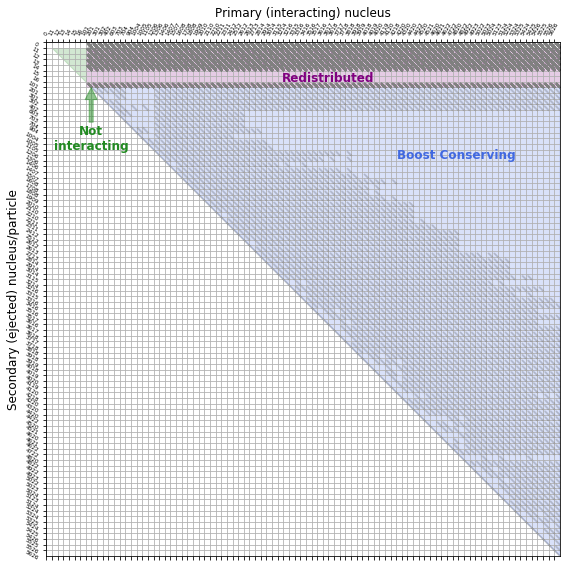

In [13]:
prince_run = prince_run_talys

precision = 0.# 1e-28
jac = prince_run.int_rates.get_hadr_jacobian(1.)

fig, ax = plt.subplots(1,1, figsize=(8,8))
 
photon = prince_run.spec_man.ncoid2sref[11]
proton = prince_run.spec_man.ncoid2sref[101]
iron = prince_run.spec_man.ncoid2sref[5626]

rect = plt.Polygon([(proton.uidx(), proton.uidx()),
                    (iron.uidx(), iron.uidx()),
                    (iron.uidx(), proton.uidx())
                   ],
                    color = 'royalblue', alpha = 0.2)
plt.annotate('Boost Conserving', (6400,1750), 
             color = 'royalblue', ha = 'center', va = 'center', fontsize = 'large', fontweight = 'bold')

ax.add_patch(rect)
rect = plt.Polygon([(proton.lidx(), photon.lidx()),
                    (proton.lidx(), proton.uidx()),
                    (iron.uidx(), proton.uidx()),
                    (iron.uidx(), photon.lidx()),
                    ],
                    color = 'purple', alpha = 0.2)
ax.add_patch(rect)
plt.annotate('Redistributed', (4400,550), 
             color = 'purple', ha = 'center', va = 'center', fontsize = 'large', fontweight = 'bold')

rect = plt.Polygon([(photon.lidx(), photon.lidx()),
#                     (photon.lidx(), proton.lidx()),
                    (proton.lidx(), photon.lidx()),
                    (proton.lidx(), proton.lidx()),
                    ],
                    color = 'forestgreen', alpha = 0.2)
ax.add_patch(rect)
plt.annotate('Not\ninteracting', (700,700), xytext = (700,1500), arrowprops=dict(facecolor='forestgreen', edgecolor = 'forestgreen', shrink=0.01, alpha = 0.5),
             color = 'forestgreen', ha = 'center', va = 'center', fontsize = 'large', fontweight = 'bold')

plt.spy(jac, markersize=0.01, precision = precision, c ='gray')
# plt.imshow(np.log(np.abs(jac.todense())),origin="upper", interpolation='nearest',cmap='binary')

ticks, labels = zip(*[(s.lidx() , s.ncoid) for s in prince_run.spec_man.species_refs][::])

ax.set_xticks(ticks)
ax.set_xticklabels(labels,rotation =60.,fontsize='xx-small')
ax.set_yticks(ticks)
ax.set_yticklabels(labels,rotation =-30, fontsize='xx-small')

ax.set_xlabel(r'Primary (interacting) nucleus',fontsize='large')

ax.xaxis.set_label_position('top') 
ax.set_ylabel(r'Secondary (ejected) nucleus/particle',fontsize='large')
ax.grid()

plt.tight_layout()
plt.savefig('../data/ref_figures/talys_couplingmat.png')

**Expected output**

![**expected output**](../data/ref_figures/talys_couplingmat.png)